# NFL Competition

# Feature Engineering e Modelo de Machine Learning

- Version: 1.0: usando padrao do fork: https://www.kaggle.com/bestpredict/location-eda-8eb410
   - Resultado: 0.012765
   
- Version: 2.0: adicionado Feature Selection com LOFO Importance
   - Resultado: 0.012744

- Version: 3.0: adicionado novas features (funçã create_features_02)
   - Resultado: 0.012802

## 1. Importa os pacotes e o dataset de treino

In [1]:
# Importar os principais pacotes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import re
import codecs
import time
import datetime
import tsfresh
import pandasql as ps

# Evitar que aparece os warnings
import warnings
warnings.filterwarnings("ignore")

# Seta algumas opções no Jupyter para exibição dos datasets
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# Variavel para controlar o treinamento no Kaggle
TRAIN_OFFLINE = True

In [2]:
# Importa os pacotes de algoritmos de regressão
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Importa os pacotes de algoritmos de redes neurais (Keras)
from keras.losses import binary_crossentropy
from keras.utils import to_categorical
from keras.layers import Dense,Input,Flatten,concatenate,Dropout,Lambda,BatchNormalization
from keras.models import Sequential, Model
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
import keras.backend as K
#from keras_lookahead import Lookahead
#from keras_radam import RAdam

# Importa pacotes do sklearn
from sklearn import preprocessing
import sklearn.metrics as mtr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler

Using TensorFlow backend.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
# train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
if TRAIN_OFFLINE:
    train = pd.read_csv('../data/train.csv', dtype={'WindSpeed': 'object'})
else:
    train = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', dtype={'WindSpeed': 'object'})
    

In [5]:
outcomes = train[['GameId','PlayId','Yards']].drop_duplicates()

## 2. Feature Engineering

In [35]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def strtofloat(x):
    try:
        return float(x)
    except:
        return -1
    
def get_time(x):
    x = x.split(":")
    return int(x[0])*60 + int(x[1])

def map_weather(txt):
    ans = 1
    if pd.isna(txt):
        return 0
    if 'partly' in txt:
        ans*=0.5
    if 'climate controlled' in txt or 'indoor' in txt:
        return ans*3
    if 'sunny' in txt or 'sun' in txt:
        return ans*2
    if 'clear' in txt:
        return ans
    if 'cloudy' in txt:
        return -ans
    if 'rain' in txt or 'rainy' in txt:
        return -2*ans
    if 'snow' in txt:
        return -3*ans
    return 0

def OffensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0, 'QB' : 0, 'RB' : 0, 'TE' : 0, 'WR' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def DefensePersonnelSplit(x):
    dic = {'DB' : 0, 'DL' : 0, 'LB' : 0, 'OL' : 0}
    for xx in x.split(","):
        xxs = xx.split(" ")
        dic[xxs[-1]] = int(xxs[-2])
    return dic

def orientation_to_cat(x):
    x = np.clip(x, 0, 360 - 1)
    try:
        return str(int(x/15))
    except:
        return "nan"    

In [36]:
def create_features(df, deploy=False):
    def new_X(x_coordinate, play_direction):
        if play_direction == 'left':
            return 120.0 - x_coordinate
        else:
            return x_coordinate

    def new_line(rush_team, field_position, yardline):
        if rush_team == field_position:
            # offense starting at X = 0 plus the 10 yard endzone plus the line of scrimmage
            return 10.0 + yardline
        else:
            # half the field plus the yards between midfield and the line of scrimmage
            return 60.0 + (50 - yardline)

    def new_orientation(angle, play_direction):
        if play_direction == 'left':
            new_angle = 360.0 - angle
            if new_angle == 360.0:
                new_angle = 0.0
            return new_angle
        else:
            return angle

    def euclidean_distance(x1,y1,x2,y2):
        x_diff = (x1-x2)**2
        y_diff = (y1-y2)**2

        return np.sqrt(x_diff + y_diff)

    def back_direction(orientation):
        if orientation > 180.0:
            return 1
        else:
            return 0

    def update_yardline(df):
        new_yardline = df[df['NflId'] == df['NflIdRusher']]
        new_yardline['YardLine'] = new_yardline[['PossessionTeam','FieldPosition','YardLine']].apply(lambda x: new_line(x[0],x[1],x[2]), axis=1)
        new_yardline = new_yardline[['GameId','PlayId','YardLine']]

        return new_yardline

    def update_orientation(df, yardline):
        df['X'] = df[['X','PlayDirection']].apply(lambda x: new_X(x[0],x[1]), axis=1)
        df['Orientation'] = df[['Orientation','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)
        df['Dir'] = df[['Dir','PlayDirection']].apply(lambda x: new_orientation(x[0],x[1]), axis=1)

        df = df.drop('YardLine', axis=1)
        df = pd.merge(df, yardline, on=['GameId','PlayId'], how='inner')

        return df

    def back_features(df):
        carriers = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','NflIdRusher','X','Y','Orientation','Dir','YardLine']]
        carriers['back_from_scrimmage'] = carriers['YardLine'] - carriers['X']
        carriers['back_oriented_down_field'] = carriers['Orientation'].apply(lambda x: back_direction(x))
        carriers['back_moving_down_field'] = carriers['Dir'].apply(lambda x: back_direction(x))
        carriers = carriers.rename(columns={'X':'back_X',
                                            'Y':'back_Y'})
        carriers = carriers[['GameId','PlayId','NflIdRusher','back_X','back_Y','back_from_scrimmage','back_oriented_down_field','back_moving_down_field']]

        return carriers

    def features_relative_to_back(df, carriers):
        player_distance = df[['GameId','PlayId','NflId','X','Y']]
        player_distance = pd.merge(player_distance, carriers, on=['GameId','PlayId'], how='inner')
        player_distance = player_distance[player_distance['NflId'] != player_distance['NflIdRusher']]
        player_distance['dist_to_back'] = player_distance[['X','Y','back_X','back_Y']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        player_distance = player_distance.groupby(['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field'])\
                                         .agg({'dist_to_back':['min','max','mean','std']})\
                                         .reset_index()
        player_distance.columns = ['GameId','PlayId','back_from_scrimmage','back_oriented_down_field','back_moving_down_field',
                                   'min_dist','max_dist','mean_dist','std_dist']

        return player_distance

    def defense_features(df):
        rusher = df[df['NflId'] == df['NflIdRusher']][['GameId','PlayId','Team','X','Y']]
        rusher.columns = ['GameId','PlayId','RusherTeam','RusherX','RusherY']

        defense = pd.merge(df,rusher,on=['GameId','PlayId'],how='inner')
        defense = defense[defense['Team'] != defense['RusherTeam']][['GameId','PlayId','X','Y','RusherX','RusherY']]
        defense['def_dist_to_back'] = defense[['X','Y','RusherX','RusherY']].apply(lambda x: euclidean_distance(x[0],x[1],x[2],x[3]), axis=1)

        defense = defense.groupby(['GameId','PlayId'])\
                         .agg({'def_dist_to_back':['min','max','mean','std']})\
                         .reset_index()
        defense.columns = ['GameId','PlayId','def_min_dist','def_max_dist','def_mean_dist','def_std_dist']

        return defense

    def static_features(df):
        
        
        add_new_feas = []

        ## Height
        df['PlayerHeight_dense'] = df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))
        
        add_new_feas.append('PlayerHeight_dense')

        ## Time
        df['TimeHandoff'] = df['TimeHandoff'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))
        df['TimeSnap'] = df['TimeSnap'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ"))

        df['TimeDelta'] = df.apply(lambda row: (row['TimeHandoff'] - row['TimeSnap']).total_seconds(), axis=1)
        df['PlayerBirthDate'] =df['PlayerBirthDate'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%Y"))

        ## Age
        seconds_in_year = 60*60*24*365.25
        df['PlayerAge'] = df.apply(lambda row: (row['TimeHandoff']-row['PlayerBirthDate']).total_seconds()/seconds_in_year, axis=1)
        add_new_feas.append('PlayerAge')

        ## WindSpeed
        df['WindSpeed_ob'] = df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
        df['WindSpeed_ob'] = df['WindSpeed_ob'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
        df['WindSpeed_dense'] = df['WindSpeed_ob'].apply(strtofloat)
        add_new_feas.append('WindSpeed_dense')

        ## Weather
        df['GameWeather_process'] = df['GameWeather'].str.lower()
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: "indoor" if not pd.isna(x) and "indoor" in x else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('coudy', 'cloudy').replace('clouidy', 'cloudy').replace('party', 'partly') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('clear and sunny', 'sunny and clear') if not pd.isna(x) else x)
        df['GameWeather_process'] = df['GameWeather_process'].apply(lambda x: x.replace('skies', '').replace("mostly", "").strip() if not pd.isna(x) else x)
        df['GameWeather_dense'] = df['GameWeather_process'].apply(map_weather)
        add_new_feas.append('GameWeather_dense')
        
#         ## Rusher
#         train['IsRusher'] = (train['NflId'] == train['NflIdRusher'])
#         train['IsRusher_ob'] = (train['NflId'] == train['NflIdRusher']).astype("object")
#         temp = train[train["IsRusher"]][["Team", "PlayId"]].rename(columns={"Team":"RusherTeam"})
#         train = train.merge(temp, on = "PlayId")
#         train["IsRusherTeam"] = train["Team"] == train["RusherTeam"]

        ## dense -> categorical
#         train["Quarter_ob"] = train["Quarter"].astype("object")
#         train["Down_ob"] = train["Down"].astype("object")
#         train["JerseyNumber_ob"] = train["JerseyNumber"].astype("object")
#         train["YardLine_ob"] = train["YardLine"].astype("object")
        # train["DefendersInTheBox_ob"] = train["DefendersInTheBox"].astype("object")
        # train["Week_ob"] = train["Week"].astype("object")
        # train["TimeDelta_ob"] = train["TimeDelta"].astype("object")


        ## Orientation and Dir
        df["Orientation_ob"] = df["Orientation"].apply(lambda x : orientation_to_cat(x)).astype("object")
        df["Dir_ob"] = df["Dir"].apply(lambda x : orientation_to_cat(x)).astype("object")

        df["Orientation_sin"] = df["Orientation"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Orientation_cos"] = df["Orientation"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        df["Dir_sin"] = df["Dir"].apply(lambda x : np.sin(x/360 * 2 * np.pi))
        df["Dir_cos"] = df["Dir"].apply(lambda x : np.cos(x/360 * 2 * np.pi))
        
        add_new_feas.append("Dir_sin")
        add_new_feas.append("Dir_cos")

        ## diff Score
        df["diffScoreBeforePlay"] = df["HomeScoreBeforePlay"] - df["VisitorScoreBeforePlay"]
        add_new_feas.append("diffScoreBeforePlay")
    
        static_features = df[df['NflId'] == df['NflIdRusher']][add_new_feas+['GameId','PlayId','X','Y','S','A','Dis','Orientation','Dir',
                                                                             'YardLine','Quarter','Down','Distance','DefendersInTheBox',
                                                                             'NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr',
                                                                             'VisitorTeamAbbr','PlayDirection','GameClock','Season','Team','FieldPosition']].drop_duplicates()
        static_features.fillna(-999,inplace=True)

        return static_features


    def combine_features(relative_to_back, defense, static, deploy=deploy):
        df = pd.merge(relative_to_back,defense,on=['GameId','PlayId'],how='inner')
        df = pd.merge(df,static,on=['GameId','PlayId'],how='inner')

        if not deploy:
            df = pd.merge(df, outcomes, on=['GameId','PlayId'], how='inner')

        return df
    
    yardline = update_yardline(df)
    df = update_orientation(df, yardline)
    back_feats = back_features(df)
    rel_back = features_relative_to_back(df, back_feats)
    def_feats = defense_features(df)
    static_feats = static_features(df)
    basetable = combine_features(rel_back, def_feats, static_feats, deploy=deploy)
    
    return basetable

In [37]:
def create_features_02(t_):
    t_['fe1'] = pd.Series(np.sqrt(np.absolute(np.square(t_.X.values) - np.square(t_.Y.values))))
    t_['fe5'] = np.square(t_['S'].values) + 2 * t_['A'].values * t_['Dis'].values  # N
    t_['fe7'] = np.arccos(np.clip(t_['X'].values / t_['Y'].values, -1, 1))  # N
    t_['fe8'] = t_['S'].values / np.clip(t_['fe1'].values, 0.6, None)
    radian_angle = (90 - t_['Dir']) * np.pi / 180.0
    t_['fe10'] = np.abs(t_['S'] * np.cos(radian_angle))
    t_['fe11'] = np.abs(t_['S'] * np.sin(radian_angle))
    
    t_["is_rusher"]          = 1.0*(t_["NflId"] == t_["NflIdRusher"])
    t_["is_home"]            = t_["Team"] == "home"
    t_["is_possession_team"] = 1.0*(t_["PossessionTeam"] == t_["HomeTeamAbbr"]) - 1.0*(t_["PossessionTeam"] == t_["VisitorTeamAbbr"])
    t_["is_field_team"]      = 1.0*(t_["FieldPosition"] == t_["HomeTeamAbbr"]) - 1.0*(t_["FieldPosition"] == t_["VisitorTeamAbbr"])
    t_["is_left"]            = t_["PlayDirection"] == "left"
    
    t_["game_time"]   = t_["GameClock"].apply(get_time)
    t_["old_data"]    = t_["Season"] == 2017
    
    t_['YardLine_std'] = 100 - t_['YardLine']
    
    return t_

In [38]:
%time train_basetable = create_features(train, False)

CPU times: user 3min 6s, sys: 6.24 s, total: 3min 13s
Wall time: 3min


In [39]:
#%time train_basetable = create_features_02(train_basetable)

CPU times: user 153 ms, sys: 31.6 ms, total: 184 ms
Wall time: 69.1 ms


In [42]:
train_basetable.drop(['NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','PlayDirection','GameClock','Season','Team','FieldPosition'], axis=1, inplace=True)

In [43]:
# Cria uma copia do dataset para backup
X = train_basetable.copy()
X.shape

(23171, 47)

In [44]:
X.head()

,GameId,PlayId,back_from_scrimmage,back_oriented_down_field,back_moving_down_field,min_dist,max_dist,mean_dist,std_dist,def_min_dist,def_max_dist,def_mean_dist,def_std_dist,PlayerHeight_dense,PlayerAge,WindSpeed_dense,GameWeather_dense,Dir_sin,Dir_cos,diffScoreBeforePlay,X,Y,S,A,Dis,Orientation,Dir,YardLine,Quarter,Down,Distance,DefendersInTheBox,Yards,fe1,fe5,fe7,fe8,fe10,fe11,is_rusher,is_home,is_possession_team,is_field_team,is_left,game_time,old_data,YardLine_std
0,2017090700,20170907000118,-33.75,0,1,1.449724,22.415872,8.046559,4.873845,4.593310,22.415872,9.752491,5.327299,70,25.596251,8.0,1.0,-0.911690,-0.410878,0,78.75,30.53,3.63,3.35,0.38,161.98,245.74,45.0,1,3,2,6.0,8,72.591195,15.7229,0.000000,0.050006,3.309436,1.491487,1.0,True,1.0,1.0,True,854,True,55.0
1,2017090700,20170907000139,-18.07,1,1,0.792023,23.025872,8.614623,5.598683,4.287773,23.025872,10.297028,5.833217,70,25.596252,8.0,1.0,-0.740805,0.671721,0,71.07,27.16,3.06,2.41,0.34,210.70,312.20,53.0,1,1,10,6.0,3,65.675561,11.0024,0.000000,0.046593,2.266862,2.055465,1.0,True,1.0,1.0,True,832,True,47.0
2,2017090700,20170907000189,26.34,0,1,1.646390,20.726285,8.482583,4.642121,4.221670,20.726285,9.903689,5.073290,70,25.596253,8.0,1.0,-0.668612,-0.743612,0,48.66,19.11,5.77,2.42,0.60,140.82,221.96,75.0,1,1,10,7.0,5,44.750458,36.1969,0.000000,0.128937,3.857889,4.290640,1.0,True,1.0,-1.0,True,782,True,25.0
3,2017090700,20170907000345,92.47,1,1,0.918096,9.791231,5.549379,1.983128,4.528002,9.791231,6.309354,1.834174,71,26.852933,8.0,1.0,-0.995496,0.094803,0,15.53,25.36,4.45,3.20,0.46,186.22,275.44,108.0,1,2,2,9.0,2,20.048658,22.7465,0.911727,0.221960,4.429957,0.421875,1.0,True,1.0,-1.0,True,732,True,-8.0
4,2017090700,20170907000395,5.01,0,0,0.502892,21.214806,9.168819,5.611232,4.288088,21.214806,11.056456,5.900009,71,22.091819,8.0,1.0,0.375901,-0.926660,7,29.99,27.12,3.90,2.53,0.44,34.27,157.92,35.0,1,1,10,7.0,7,12.802566,17.4364,0.000000,0.304626,1.466013,3.613974,1.0,False,-1.0,-1.0,False,728,True,65.0


## 3. Feature Selection

In [45]:
import scipy.sparse as ss

class Dataset:
    """
    Dataset for LOFO
    Parameters
    ----------
    df: pandas dataframe
    target: string
        Column name for target within df
    features: list of strings
        List of column names within df
    feature_groups: dict, optional
        Name, value dictionary of feature groups as numpy.darray or scipy.csr.scr_matrix
    """

    def __init__(self, df, target, features, feature_groups=None):
        self.df = df.copy()
        self.features = list(features)
        self.feature_groups = feature_groups if feature_groups else dict()

        self.num_rows = df.shape[0]
        self.y = df[target].values

        for feature_name, feature_matrix in self.feature_groups.items():
            if not (isinstance(feature_matrix, np.ndarray) or isinstance(feature_matrix, ss.csr.csr_matrix)):
                raise Exception("Data type {dtype} is not a valid type!".format(dtype=type(feature_matrix)))

            if feature_matrix.shape[0] != self.num_rows:
                raise Exception("Expected {expected} rows but got {n} rows!".format(expected=self.num_rows,
                                                                                    n=feature_matrix.shape[0]))

            if feature_name in self.features:
                raise Exception("Feature group name '{name}' is the same with one of the features!")

    def getX(self, feature_to_remove, fit_params):
        """Get feature matrix and fit_params after removing a feature
        Parameters
        ----------
        feature_to_remove : string
            feature name to remove
        fit_params : dict
            fit parameters for the model
        Returns
        -------
        X : numpy.darray or scipy.csr.scr_matrix
            Feature matrix
        fit_params: dict
            Updated fit_params after feature removal
        """
        feature_list = [feature for feature in self.features if feature != feature_to_remove]
        concat_list = [self.df[feature_list].values]

        for feature_name, feature_matrix in self.feature_groups.items():
            if feature_name != feature_to_remove:
                concat_list.append(feature_matrix)

        fit_params = fit_params.copy()
        if "categorical_feature" in fit_params:
            cat_features = [f for f in fit_params["categorical_feature"] if f != feature_to_remove]
            fit_params["categorical_feature"] = [ix for ix, f in enumerate(feature_list) if (f in cat_features)]

        has_sparse = False
        for feature_name, feature_matrix in self.feature_groups.items():
            if feature_name != feature_to_remove and isinstance(feature_matrix, ss.csr.csr_matrix):
                has_sparse = True

        concat = np.hstack
        if has_sparse:
            concat = ss.hstack

        return concat(concat_list), fit_params

In [46]:
def plot_importance(importance_df, figsize=(8, 8)):
    """Plot feature importance
    Parameters
    ----------
    importance_df : pandas dataframe
        Output dataframe from LOFO/FLOFO get_importance
    figsize : tuple
    """
    importance_df = importance_df.copy()
    importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
    importance_df.sort_values("importance_mean", inplace=True)

    importance_df.plot(x="feature", y="importance_mean", xerr="importance_std",
                       kind='barh', color=importance_df["color"], figsize=figsize)

In [47]:
from sklearn.model_selection import cross_validate
import multiprocessing
#from lofo.infer_defaults import infer_model


class LOFOImportance:
    """
    Leave One Feature Out Importance
    Given a model and cross-validation scheme, calculates the feature importances.
    Parameters
    ----------
    dataset: LOFO Dataset object
    scoring: string or callable
        Same as scoring in sklearn API
    model: model (sklearn API), optional
        Not trained model object
    fit_params : dict, optional
        fit parameters for the model
    cv: int or iterable
        Same as cv in sklearn API
    n_jobs: int, optional
        Number of jobs for parallel computation
    """

    def __init__(self, dataset, scoring, model=None, fit_params=None, cv=4, n_jobs=None):

        self.fit_params = fit_params if fit_params else dict()
        if model is None:
            model, dataset.df, categoricals, dataset.y = infer_model(dataset.df, dataset.features, dataset.y, n_jobs)
            self.fit_params["categorical_feature"] = categoricals
            n_jobs = 1

        self.model = model
        self.dataset = dataset
        self.scoring = scoring
        self.cv = cv
        self.n_jobs = n_jobs
        if self.n_jobs is not None and self.n_jobs > 1:
            warning_str = ("Warning: If your model is multithreaded, please initialise the number"
                           "of jobs of LOFO to be equal to 1, otherwise you may experience performance issues.")
            warnings.warn(warning_str)

    def _get_cv_score(self, feature_to_remove):
        X, fit_params = self.dataset.getX(feature_to_remove=feature_to_remove, fit_params=self.fit_params)
        y = self.dataset.y

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_results = cross_validate(self.model, X, y, cv=self.cv, scoring=self.scoring, fit_params=fit_params)
        return cv_results['test_score']

    def _get_cv_score_parallel(self, feature, result_queue):
        test_score = self._get_cv_score(feature_to_remove=feature)
        result_queue.put((feature, test_score))
        return test_score

    def get_importance(self):
        """Run LOFO to get feature importances
        Returns
        -------
        importance_df : pandas dataframe
            Dataframe with feature names and corresponding importance mean and std (sorted by importance)
        """
        base_cv_score = self._get_cv_score(feature_to_remove=None)
        feature_list = self.dataset.features + list(self.dataset.feature_groups.keys())

        if self.n_jobs is not None and self.n_jobs > 1:

            pool = multiprocessing.Pool(self.n_jobs)
            manager = multiprocessing.Manager()
            result_queue = manager.Queue()

            for f in feature_list:
                pool.apply_async(self._get_cv_score_parallel, (f, result_queue))

            pool.close()
            pool.join()

            lofo_cv_result = [result_queue.get() for _ in range(len(feature_list))]
            lofo_cv_scores_normalized = np.array([base_cv_score - lofo_cv_score for _, lofo_cv_score in lofo_cv_result])
            feature_list = [feature for feature, _ in lofo_cv_result]
        else:
            lofo_cv_scores = []
            for f in tqdm_notebook(feature_list):
                lofo_cv_scores.append(self._get_cv_score(feature_to_remove=f))

            lofo_cv_scores_normalized = np.array([base_cv_score - lofo_cv_score for lofo_cv_score in lofo_cv_scores])

        importance_df = pd.DataFrame()
        importance_df["feature"] = feature_list
        importance_df["importance_mean"] = lofo_cv_scores_normalized.mean(axis=1)
        importance_df["importance_std"] = lofo_cv_scores_normalized.std(axis=1)

        return importance_df.sort_values("importance_mean", ascending=False)

In [48]:
# Procedimento para verificar as features mais importantes
# Usando LightGBM para treinamento
#from lofo import LOFOImportance, Dataset, plot_importance

n_folds = 5
kfold_lgb = KFold(n_folds, shuffle=True)

features = [x for x in X.columns if x not in ['Yards','GameId','PlayId']]

params2 = {'num_leaves': 15,
          'objective': 'mae',
          #'learning_rate': 0.1,
          "boosting": "gbdt",
          "num_rounds": 150
          }

model_lgb = lgb.LGBMRegressor(**params2)
dataset = Dataset(df=X, target="Yards", features=features)
lofo_imp = LOFOImportance(dataset, model=model_lgb, cv=kfold_lgb, scoring="neg_mean_absolute_error")

importance_df = lofo_imp.get_importance()

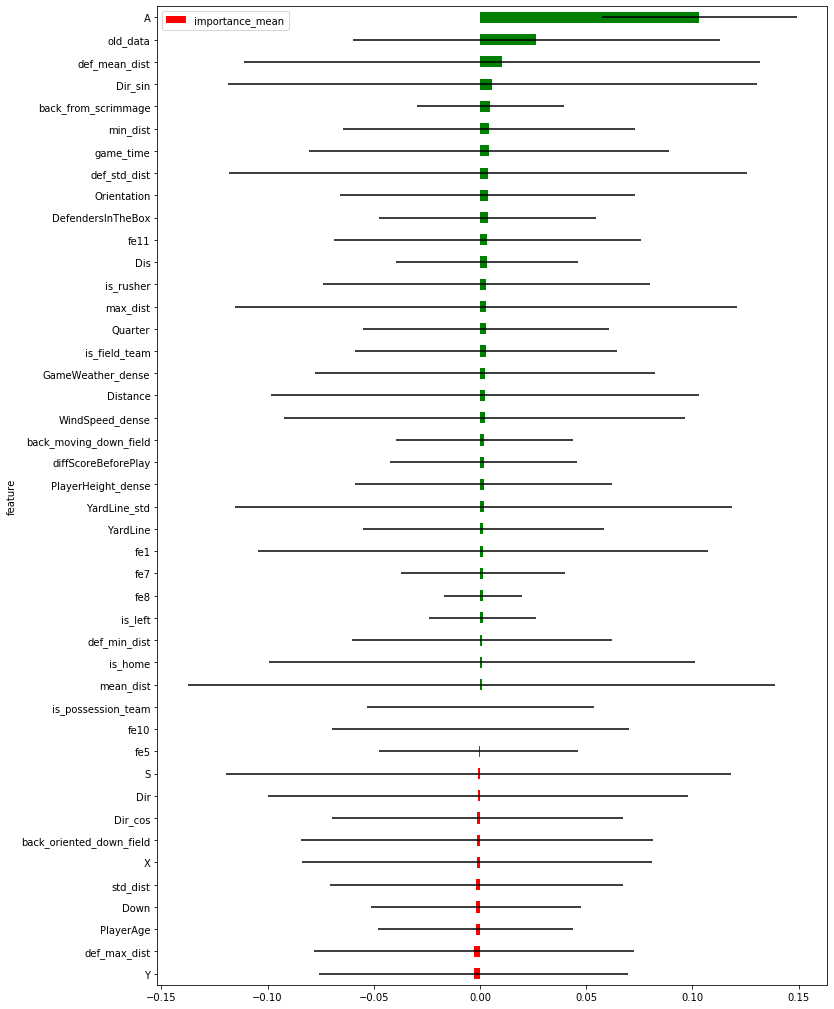

In [49]:
# Exibindo grafico com as features
plot_importance(importance_df, figsize=(12, 18))

In [50]:
best_features = importance_df.loc[importance_df['importance_mean'] > 0].feature
best_features

21                         A
42                  old_data
9              def_mean_dist
15                   Dir_sin
0        back_from_scrimmage
3                   min_dist
41                 game_time
10              def_std_dist
23               Orientation
29         DefendersInTheBox
35                      fe11
22                       Dis
36                 is_rusher
4                   max_dist
26                   Quarter
39             is_field_team
14         GameWeather_dense
28                  Distance
13           WindSpeed_dense
2     back_moving_down_field
17       diffScoreBeforePlay
11        PlayerHeight_dense
43              YardLine_std
25                  YardLine
30                       fe1
32                       fe7
33                       fe8
40                   is_left
7               def_min_dist
37                   is_home
5                  mean_dist
38        is_possession_team
34                      fe10
Name: feature, dtype: object

## 4. Criar e avaliar alguns algoritmos de Machine Learning

### 4.1. Split Treino e Validação

In [51]:
# Criar um dataset somente com as colunas mais importantes conforme visto anteriormente
new_X = X.loc[:,best_features]
#new_X = X.drop(['GameId','PlayId','Yards'], axis=1)
target = X.Yards

y = np.zeros((target.shape[0], 199))
for idx, target in enumerate(list(target)):
    y[idx][99 + target] = 1
    
# Normalizando as variaveis do dataset de treino
scaler = StandardScaler()
new_X = scaler.fit_transform(new_X)
new_X.shape, y.shape

((23171, 33), (23171, 199))

### 4.3. Teste com Keras (New NN Struct)

In [52]:
class CRPSCallback(Callback):
    
    def __init__(self,validation, predict_batch_size=20, include_on_batch=False):
        super(CRPSCallback, self).__init__()
        self.validation = validation
        self.predict_batch_size = predict_batch_size
        self.include_on_batch = include_on_batch
        
        print('validation shape',len(self.validation))

    def on_batch_begin(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        if not ('CRPS_score_val' in self.params['metrics']):
            self.params['metrics'].append('CRPS_score_val')

    def on_batch_end(self, batch, logs={}):
        if (self.include_on_batch):
            logs['CRPS_score_val'] = float('-inf')

    def on_epoch_end(self, epoch, logs={}):
        logs['CRPS_score_val'] = float('-inf')
            
        if (self.validation):
            X_valid, y_valid = self.validation[0], self.validation[1]
            y_pred = self.model.predict(X_valid)
            y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
            y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
            val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * X_valid.shape[0])
            val_s = np.round(val_s, 6)
            logs['CRPS_score_val'] = val_s

In [53]:
def get_model(x_tr,y_tr,x_val,y_val):
    inp = Input(shape = (x_tr.shape[1],))
    x = Dense(1024, input_dim=X.shape[1], activation='relu')(inp)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    out = Dense(199, activation='softmax')(x)
    model = Model(inp,out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[])
    
    #add lookahead
#     lookahead = Lookahead(k=5, alpha=0.5) # Initialize Lookahead
#     lookahead.inject(model) # add into model

    
    es = EarlyStopping(monitor='CRPS_score_val', 
                       mode='min',
                       restore_best_weights=True, 
                       verbose=1, 
                       patience=10)

    mc = ModelCheckpoint('best_model.h5',monitor='CRPS_score_val',mode='min',save_best_only=True, verbose=1, save_weights_only=True)
    
    bsz = 1024
    steps = x_tr.shape[0]/bsz
    
    model.fit(x_tr, y_tr,callbacks=[CRPSCallback(validation = (x_val,y_val)),es,mc], epochs=100, batch_size=bsz,verbose=1)
    model.load_weights("best_model.h5")
    
    y_pred = model.predict(x_val)
    y_valid = y_val
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * x_val.shape[0])
    crps = np.round(val_s, 6)

    return model,crps

In [54]:
def predict(x_te):
    model_num = len(models)
    for k,m in enumerate(models):
        if k==0:
            y_pred = m.predict(x_te,batch_size=1024)
        else:
            y_pred+=m.predict(x_te,batch_size=1024)
            
    y_pred = y_pred / model_num
    
    return y_pred

In [56]:
losses = []
models = []
crps_csv = []

s_time = time.time()

for k in range(2):
    kfold = KFold(10, random_state = 42 + k, shuffle = True)
    for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(y)):
        print("-----------")
        print("-----------")
        tr_x,tr_y = new_X[tr_inds],y[tr_inds]
        val_x,val_y = new_X[val_inds],y[val_inds]
        model,crps = get_model(tr_x,tr_y,val_x,val_y)
        models.append(model)
        print("the %d fold crps is %f"%((k_fold+1),crps))
        crps_csv.append(crps)

#print("mean crps is %f"%np.mean(crps_csv))

-----------
-----------
validation shape 2
Epoch 1/100
20853/20853 [==============================] - 2s 106us/step - loss: 5.5786

Epoch 00001: CRPS_score_val improved from inf to 0.08213, saving model to best_model.h5
Epoch 2/100
20853/20853 [==============================] - 2s 75us/step - loss: 5.1091

Epoch 00002: CRPS_score_val improved from 0.08213 to 0.07642, saving model to best_model.h5
Epoch 3/100
20853/20853 [==============================] - 1s 70us/step - loss: 4.6785

Epoch 00003: CRPS_score_val improved from 0.07642 to 0.05942, saving model to best_model.h5
Epoch 4/100
20853/20853 [==============================] - 1s 71us/step - loss: 4.2163

Epoch 00004: CRPS_score_val improved from 0.05942 to 0.03519, saving model to best_model.h5
Epoch 5/100
20853/20853 [==============================] - 2s 77us/step - loss: 3.7535

Epoch 00005: CRPS_score_val improved from 0.03519 to 0.02071, saving model to best_model.h5
Epoch 6/100
20853/20853 [==============================] - 2

Epoch 49/100
20853/20853 [==============================] - 1s 71us/step - loss: 2.6431

Epoch 00049: CRPS_score_val did not improve from 0.01286
Epoch 50/100
20853/20853 [==============================] - 1s 68us/step - loss: 2.6395

Epoch 00050: CRPS_score_val did not improve from 0.01286
Epoch 51/100
20853/20853 [==============================] - 1s 70us/step - loss: 2.6359

Epoch 00051: CRPS_score_val did not improve from 0.01286
Epoch 52/100
20853/20853 [==============================] - 2s 76us/step - loss: 2.6352

Epoch 00052: CRPS_score_val did not improve from 0.01286
Epoch 53/100
20853/20853 [==============================] - 2s 78us/step - loss: 2.6320

Epoch 00053: CRPS_score_val did not improve from 0.01286
Epoch 54/100
20853/20853 [==============================] - 1s 67us/step - loss: 2.6252

Epoch 00054: CRPS_score_val did not improve from 0.01286
Epoch 55/100
20853/20853 [==============================] - 1s 66us/step - loss: 2.6281

Epoch 00055: CRPS_score_val did not

20854/20854 [==============================] - 2s 73us/step - loss: 2.7181

Epoch 00027: CRPS_score_val improved from 0.01293 to 0.01292, saving model to best_model.h5
Epoch 28/100
20854/20854 [==============================] - 1s 72us/step - loss: 2.7120

Epoch 00028: CRPS_score_val improved from 0.01292 to 0.01291, saving model to best_model.h5
Epoch 29/100
20854/20854 [==============================] - 1s 72us/step - loss: 2.7089

Epoch 00029: CRPS_score_val improved from 0.01291 to 0.01289, saving model to best_model.h5
Epoch 30/100
20854/20854 [==============================] - 2s 72us/step - loss: 2.7044

Epoch 00030: CRPS_score_val did not improve from 0.01289
Epoch 31/100
20854/20854 [==============================] - 1s 70us/step - loss: 2.6986

Epoch 00031: CRPS_score_val did not improve from 0.01289
Epoch 32/100
20854/20854 [==============================] - 1s 69us/step - loss: 2.6984

Epoch 00032: CRPS_score_val did not improve from 0.01289
Epoch 33/100
20854/20854 [======

20854/20854 [==============================] - 1s 72us/step - loss: 2.7359

Epoch 00021: CRPS_score_val improved from 0.01289 to 0.01288, saving model to best_model.h5
Epoch 22/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.7296

Epoch 00022: CRPS_score_val improved from 0.01288 to 0.01287, saving model to best_model.h5
Epoch 23/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.7216

Epoch 00023: CRPS_score_val improved from 0.01287 to 0.01286, saving model to best_model.h5
Epoch 24/100
20854/20854 [==============================] - 2s 72us/step - loss: 2.7198

Epoch 00024: CRPS_score_val improved from 0.01286 to 0.01284, saving model to best_model.h5
Epoch 25/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.7153

Epoch 00025: CRPS_score_val improved from 0.01284 to 0.01281, saving model to best_model.h5
Epoch 26/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.7117

Epoch 00026: CRPS_s

20854/20854 [==============================] - 2s 74us/step - loss: 3.7515

Epoch 00005: CRPS_score_val improved from 0.03738 to 0.02267, saving model to best_model.h5
Epoch 6/100
20854/20854 [==============================] - 2s 76us/step - loss: 3.3526

Epoch 00006: CRPS_score_val improved from 0.02267 to 0.01615, saving model to best_model.h5
Epoch 7/100
20854/20854 [==============================] - 2s 74us/step - loss: 3.1215

Epoch 00007: CRPS_score_val improved from 0.01615 to 0.01424, saving model to best_model.h5
Epoch 8/100
20854/20854 [==============================] - 1s 71us/step - loss: 2.9829

Epoch 00008: CRPS_score_val improved from 0.01424 to 0.01367, saving model to best_model.h5
Epoch 9/100
20854/20854 [==============================] - 1s 69us/step - loss: 2.9070

Epoch 00009: CRPS_score_val improved from 0.01367 to 0.01347, saving model to best_model.h5
Epoch 10/100
20854/20854 [==============================] - 1s 69us/step - loss: 2.8722

Epoch 00010: CRPS_score

20854/20854 [==============================] - 2s 83us/step - loss: 2.6317

Epoch 00053: CRPS_score_val did not improve from 0.01278
Epoch 54/100
20854/20854 [==============================] - 2s 74us/step - loss: 2.6281

Epoch 00054: CRPS_score_val did not improve from 0.01278
Epoch 55/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.6298

Epoch 00055: CRPS_score_val did not improve from 0.01278
Epoch 56/100
20854/20854 [==============================] - 2s 83us/step - loss: 2.6287

Epoch 00056: CRPS_score_val did not improve from 0.01278
Epoch 57/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.6257

Epoch 00057: CRPS_score_val did not improve from 0.01278
Epoch 58/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6189

Epoch 00058: CRPS_score_val did not improve from 0.01278
Epoch 59/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.6172

Epoch 00059: CRPS_score_val did not improve from

Epoch 27/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.7062

Epoch 00027: CRPS_score_val improved from 0.01311 to 0.01310, saving model to best_model.h5
Epoch 28/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.7069

Epoch 00028: CRPS_score_val improved from 0.01310 to 0.01310, saving model to best_model.h5
Epoch 29/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.6977

Epoch 00029: CRPS_score_val improved from 0.01310 to 0.01310, saving model to best_model.h5
Epoch 30/100
20854/20854 [==============================] - 2s 74us/step - loss: 2.6939

Epoch 00030: CRPS_score_val improved from 0.01310 to 0.01308, saving model to best_model.h5
Epoch 31/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.6933

Epoch 00031: CRPS_score_val improved from 0.01308 to 0.01308, saving model to best_model.h5
Epoch 32/100
20854/20854 [==============================] - 2s 74us/step - loss: 2.6886

Epoch 

20854/20854 [==============================] - 2s 82us/step - loss: 2.7054

Epoch 00028: CRPS_score_val improved from 0.01257 to 0.01257, saving model to best_model.h5
Epoch 29/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.7037

Epoch 00029: CRPS_score_val improved from 0.01257 to 0.01253, saving model to best_model.h5
Epoch 30/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.6952

Epoch 00030: CRPS_score_val did not improve from 0.01253
Epoch 31/100
20854/20854 [==============================] - 2s 82us/step - loss: 2.6991

Epoch 00031: CRPS_score_val improved from 0.01253 to 0.01251, saving model to best_model.h5
Epoch 32/100
20854/20854 [==============================] - 2s 77us/step - loss: 2.6921

Epoch 00032: CRPS_score_val did not improve from 0.01251
Epoch 33/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.6869

Epoch 00033: CRPS_score_val did not improve from 0.01251
Epoch 34/100
20854/20854 [======

Epoch 6/100
20854/20854 [==============================] - 2s 95us/step - loss: 3.3762

Epoch 00006: CRPS_score_val improved from 0.02231 to 0.01585, saving model to best_model.h5
Epoch 7/100
20854/20854 [==============================] - 2s 91us/step - loss: 3.1371

Epoch 00007: CRPS_score_val improved from 0.01585 to 0.01385, saving model to best_model.h5
Epoch 8/100
20854/20854 [==============================] - 2s 89us/step - loss: 2.9999

Epoch 00008: CRPS_score_val improved from 0.01385 to 0.01313, saving model to best_model.h5
Epoch 9/100
20854/20854 [==============================] - 2s 88us/step - loss: 2.9321

Epoch 00009: CRPS_score_val improved from 0.01313 to 0.01283, saving model to best_model.h5
Epoch 10/100
20854/20854 [==============================] - 2s 95us/step - loss: 2.8715

Epoch 00010: CRPS_score_val improved from 0.01283 to 0.01275, saving model to best_model.h5
Epoch 11/100
20854/20854 [==============================] - 2s 92us/step - loss: 2.8471

Epoch 0001

20854/20854 [==============================] - 2s 78us/step - loss: 2.6301

Epoch 00055: CRPS_score_val did not improve from 0.01217
Epoch 56/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6247

Epoch 00056: CRPS_score_val improved from 0.01217 to 0.01216, saving model to best_model.h5
Epoch 57/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.6219

Epoch 00057: CRPS_score_val did not improve from 0.01216
Epoch 58/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.6246

Epoch 00058: CRPS_score_val did not improve from 0.01216
Epoch 59/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.6184

Epoch 00059: CRPS_score_val did not improve from 0.01216
Epoch 60/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.6146

Epoch 00060: CRPS_score_val did not improve from 0.01216
Epoch 61/100
20854/20854 [==============================] - 2s 77us/step - loss: 2.6104

Epoch 00061: 

20854/20854 [==============================] - 2s 72us/step - loss: 2.7161

Epoch 00026: CRPS_score_val improved from 0.01325 to 0.01324, saving model to best_model.h5
Epoch 27/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.7045

Epoch 00027: CRPS_score_val improved from 0.01324 to 0.01323, saving model to best_model.h5
Epoch 28/100
20854/20854 [==============================] - 2s 72us/step - loss: 2.7067

Epoch 00028: CRPS_score_val improved from 0.01323 to 0.01323, saving model to best_model.h5
Epoch 29/100
20854/20854 [==============================] - 1s 70us/step - loss: 2.6990

Epoch 00029: CRPS_score_val improved from 0.01323 to 0.01322, saving model to best_model.h5
Epoch 30/100
20854/20854 [==============================] - 1s 70us/step - loss: 2.6956

Epoch 00030: CRPS_score_val did not improve from 0.01322
Epoch 31/100
20854/20854 [==============================] - 1s 69us/step - loss: 2.6957

Epoch 00031: CRPS_score_val improved from 0.01322 to 0

20854/20854 [==============================] - 2s 78us/step - loss: 2.7449

Epoch 00019: CRPS_score_val improved from 0.01285 to 0.01282, saving model to best_model.h5
Epoch 20/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.7446

Epoch 00020: CRPS_score_val improved from 0.01282 to 0.01278, saving model to best_model.h5
Epoch 21/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.7416

Epoch 00021: CRPS_score_val improved from 0.01278 to 0.01274, saving model to best_model.h5
Epoch 22/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.7320

Epoch 00022: CRPS_score_val did not improve from 0.01274
Epoch 23/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.7254

Epoch 00023: CRPS_score_val improved from 0.01274 to 0.01271, saving model to best_model.h5
Epoch 24/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.7223

Epoch 00024: CRPS_score_val improved from 0.01271 to 0

20854/20854 [==============================] - 2s 83us/step - loss: 2.9841

Epoch 00008: CRPS_score_val improved from 0.01499 to 0.01440, saving model to best_model.h5
Epoch 9/100
20854/20854 [==============================] - 2s 83us/step - loss: 2.9121

Epoch 00009: CRPS_score_val improved from 0.01440 to 0.01417, saving model to best_model.h5
Epoch 10/100
20854/20854 [==============================] - 2s 81us/step - loss: 2.8709

Epoch 00010: CRPS_score_val improved from 0.01417 to 0.01407, saving model to best_model.h5
Epoch 11/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.8410

Epoch 00011: CRPS_score_val improved from 0.01407 to 0.01402, saving model to best_model.h5
Epoch 12/100
20854/20854 [==============================] - 2s 82us/step - loss: 2.8215

Epoch 00012: CRPS_score_val improved from 0.01402 to 0.01395, saving model to best_model.h5
Epoch 13/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.8001

Epoch 00013: CRPS_sc

20854/20854 [==============================] - 2s 82us/step - loss: 2.6258

Epoch 00058: CRPS_score_val did not improve from 0.01347
Epoch 59/100
20854/20854 [==============================] - 2s 84us/step - loss: 2.6130

Epoch 00059: CRPS_score_val did not improve from 0.01347
Epoch 60/100
20854/20854 [==============================] - 2s 82us/step - loss: 2.6135

Epoch 00060: CRPS_score_val did not improve from 0.01347
Epoch 61/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6088
Restoring model weights from the end of the best epoch

Epoch 00061: CRPS_score_val did not improve from 0.01347
Epoch 00061: early stopping
the 10 fold crps is 0.013474
-----------
-----------
validation shape 2
Epoch 1/100
20853/20853 [==============================] - 3s 122us/step - loss: 5.5896

Epoch 00001: CRPS_score_val improved from inf to 0.08256, saving model to best_model.h5
Epoch 2/100
20853/20853 [==============================] - 1s 72us/step - loss: 5.1117

Epoch 000

20853/20853 [==============================] - 2s 77us/step - loss: 2.6603

Epoch 00045: CRPS_score_val did not improve from 0.01244
Epoch 46/100
20853/20853 [==============================] - 2s 78us/step - loss: 2.6529

Epoch 00046: CRPS_score_val did not improve from 0.01244
Epoch 47/100
20853/20853 [==============================] - 2s 80us/step - loss: 2.6504

Epoch 00047: CRPS_score_val improved from 0.01244 to 0.01243, saving model to best_model.h5
Epoch 48/100
20853/20853 [==============================] - 2s 82us/step - loss: 2.6475

Epoch 00048: CRPS_score_val did not improve from 0.01243
Epoch 49/100
20853/20853 [==============================] - 2s 78us/step - loss: 2.6452

Epoch 00049: CRPS_score_val did not improve from 0.01243
Epoch 50/100
20853/20853 [==============================] - 2s 89us/step - loss: 2.6469

Epoch 00050: CRPS_score_val did not improve from 0.01243
Epoch 51/100
20853/20853 [==============================] - 2s 98us/step - loss: 2.6385

Epoch 00051: 

20854/20854 [==============================] - 2s 80us/step - loss: 2.6823

Epoch 00035: CRPS_score_val improved from 0.01257 to 0.01254, saving model to best_model.h5
Epoch 36/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.6830

Epoch 00036: CRPS_score_val did not improve from 0.01254
Epoch 37/100
20854/20854 [==============================] - 2s 77us/step - loss: 2.6777

Epoch 00037: CRPS_score_val did not improve from 0.01254
Epoch 38/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.6723

Epoch 00038: CRPS_score_val improved from 0.01254 to 0.01254, saving model to best_model.h5
Epoch 39/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.6724

Epoch 00039: CRPS_score_val did not improve from 0.01254
Epoch 40/100
20854/20854 [==============================] - 2s 87us/step - loss: 2.6706

Epoch 00040: CRPS_score_val did not improve from 0.01254
Epoch 41/100
20854/20854 [==============================] - 2s 92us

20854/20854 [==============================] - 2s 85us/step - loss: 2.7156

Epoch 00025: CRPS_score_val improved from 0.01330 to 0.01328, saving model to best_model.h5
Epoch 26/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.7118

Epoch 00026: CRPS_score_val did not improve from 0.01328
Epoch 27/100
20854/20854 [==============================] - 2s 81us/step - loss: 2.7077

Epoch 00027: CRPS_score_val improved from 0.01328 to 0.01328, saving model to best_model.h5
Epoch 28/100
20854/20854 [==============================] - 2s 77us/step - loss: 2.7033

Epoch 00028: CRPS_score_val improved from 0.01328 to 0.01326, saving model to best_model.h5
Epoch 29/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.7009

Epoch 00029: CRPS_score_val improved from 0.01326 to 0.01325, saving model to best_model.h5
Epoch 30/100
20854/20854 [==============================] - 2s 81us/step - loss: 2.6984

Epoch 00030: CRPS_score_val did not improve from 0.013

20854/20854 [==============================] - 2s 84us/step - loss: 2.7687

Epoch 00016: CRPS_score_val improved from 0.01326 to 0.01322, saving model to best_model.h5
Epoch 17/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.7658

Epoch 00017: CRPS_score_val improved from 0.01322 to 0.01318, saving model to best_model.h5
Epoch 18/100
20854/20854 [==============================] - 2s 82us/step - loss: 2.7545

Epoch 00018: CRPS_score_val improved from 0.01318 to 0.01315, saving model to best_model.h5
Epoch 19/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.7454

Epoch 00019: CRPS_score_val improved from 0.01315 to 0.01312, saving model to best_model.h5
Epoch 20/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.7388

Epoch 00020: CRPS_score_val improved from 0.01312 to 0.01310, saving model to best_model.h5
Epoch 21/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.7333

Epoch 00021: CRPS_s

20854/20854 [==============================] - 2s 74us/step - loss: 2.7897

Epoch 00014: CRPS_score_val improved from 0.01281 to 0.01277, saving model to best_model.h5
Epoch 15/100
20854/20854 [==============================] - 2s 81us/step - loss: 2.7774

Epoch 00015: CRPS_score_val improved from 0.01277 to 0.01271, saving model to best_model.h5
Epoch 16/100
20854/20854 [==============================] - 2s 81us/step - loss: 2.7735

Epoch 00016: CRPS_score_val improved from 0.01271 to 0.01269, saving model to best_model.h5
Epoch 17/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.7604

Epoch 00017: CRPS_score_val improved from 0.01269 to 0.01266, saving model to best_model.h5
Epoch 18/100
20854/20854 [==============================] - 2s 73us/step - loss: 2.7567

Epoch 00018: CRPS_score_val improved from 0.01266 to 0.01262, saving model to best_model.h5
Epoch 19/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.7534

Epoch 00019: CRPS_s

Epoch 3/100
20854/20854 [==============================] - 1s 69us/step - loss: 4.6342

Epoch 00003: CRPS_score_val improved from 0.07480 to 0.05656, saving model to best_model.h5
Epoch 4/100
20854/20854 [==============================] - 1s 69us/step - loss: 4.1784

Epoch 00004: CRPS_score_val improved from 0.05656 to 0.03369, saving model to best_model.h5
Epoch 5/100
20854/20854 [==============================] - 1s 70us/step - loss: 3.7404

Epoch 00005: CRPS_score_val improved from 0.03369 to 0.02014, saving model to best_model.h5
Epoch 6/100
20854/20854 [==============================] - 2s 73us/step - loss: 3.3724

Epoch 00006: CRPS_score_val improved from 0.02014 to 0.01556, saving model to best_model.h5
Epoch 7/100
20854/20854 [==============================] - 2s 77us/step - loss: 3.1223

Epoch 00007: CRPS_score_val improved from 0.01556 to 0.01386, saving model to best_model.h5
Epoch 8/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.9859

Epoch 00008:

20854/20854 [==============================] - 2s 77us/step - loss: 2.6406

Epoch 00051: CRPS_score_val did not improve from 0.01250
Epoch 52/100
20854/20854 [==============================] - 2s 76us/step - loss: 2.6369

Epoch 00052: CRPS_score_val did not improve from 0.01250
Epoch 53/100
20854/20854 [==============================] - 2s 85us/step - loss: 2.6325

Epoch 00053: CRPS_score_val did not improve from 0.01250
Epoch 54/100
20854/20854 [==============================] - 2s 83us/step - loss: 2.6341

Epoch 00054: CRPS_score_val did not improve from 0.01250
Epoch 55/100
20854/20854 [==============================] - 2s 84us/step - loss: 2.6289

Epoch 00055: CRPS_score_val did not improve from 0.01250
Epoch 56/100
20854/20854 [==============================] - 2s 86us/step - loss: 2.6295

Epoch 00056: CRPS_score_val did not improve from 0.01250
Epoch 57/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.6213

Epoch 00057: CRPS_score_val improved from 0.0125

20854/20854 [==============================] - 2s 77us/step - loss: 2.6976

Epoch 00032: CRPS_score_val did not improve from 0.01289
Epoch 33/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.6922

Epoch 00033: CRPS_score_val improved from 0.01289 to 0.01287, saving model to best_model.h5
Epoch 34/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.6910

Epoch 00034: CRPS_score_val did not improve from 0.01287
Epoch 35/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6879

Epoch 00035: CRPS_score_val improved from 0.01287 to 0.01286, saving model to best_model.h5
Epoch 36/100
20854/20854 [==============================] - 2s 77us/step - loss: 2.6844

Epoch 00036: CRPS_score_val did not improve from 0.01286
Epoch 37/100
20854/20854 [==============================] - 2s 79us/step - loss: 2.6820

Epoch 00037: CRPS_score_val did not improve from 0.01286
Epoch 38/100
20854/20854 [==============================] - 2s 79us

20854/20854 [==============================] - 2s 83us/step - loss: 2.8555

Epoch 00010: CRPS_score_val improved from 0.01466 to 0.01457, saving model to best_model.h5
Epoch 11/100
20854/20854 [==============================] - 2s 84us/step - loss: 2.8330

Epoch 00011: CRPS_score_val improved from 0.01457 to 0.01451, saving model to best_model.h5
Epoch 12/100
20854/20854 [==============================] - 2s 86us/step - loss: 2.8189

Epoch 00012: CRPS_score_val improved from 0.01451 to 0.01445, saving model to best_model.h5
Epoch 13/100
20854/20854 [==============================] - 2s 82us/step - loss: 2.7974

Epoch 00013: CRPS_score_val improved from 0.01445 to 0.01440, saving model to best_model.h5
Epoch 14/100
20854/20854 [==============================] - 2s 84us/step - loss: 2.7832

Epoch 00014: CRPS_score_val improved from 0.01440 to 0.01435, saving model to best_model.h5
Epoch 15/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.7764

Epoch 00015: CRPS_s

20854/20854 [==============================] - 1s 71us/step - loss: 5.1052

Epoch 00002: CRPS_score_val improved from 0.08233 to 0.07643, saving model to best_model.h5
Epoch 3/100
20854/20854 [==============================] - 2s 72us/step - loss: 4.6604

Epoch 00003: CRPS_score_val improved from 0.07643 to 0.05865, saving model to best_model.h5
Epoch 4/100
20854/20854 [==============================] - 2s 73us/step - loss: 4.1962

Epoch 00004: CRPS_score_val improved from 0.05865 to 0.03622, saving model to best_model.h5
Epoch 5/100
20854/20854 [==============================] - 2s 75us/step - loss: 3.7469

Epoch 00005: CRPS_score_val improved from 0.03622 to 0.02181, saving model to best_model.h5
Epoch 6/100
20854/20854 [==============================] - 2s 89us/step - loss: 3.3732

Epoch 00006: CRPS_score_val improved from 0.02181 to 0.01649, saving model to best_model.h5
Epoch 7/100
20854/20854 [==============================] - 2s 82us/step - loss: 3.1306

Epoch 00007: CRPS_score_

20854/20854 [==============================] - 2s 79us/step - loss: 2.6446

Epoch 00050: CRPS_score_val did not improve from 0.01265
Epoch 51/100
20854/20854 [==============================] - 2s 82us/step - loss: 2.6407

Epoch 00051: CRPS_score_val did not improve from 0.01265
Epoch 52/100
20854/20854 [==============================] - 2s 81us/step - loss: 2.6411

Epoch 00052: CRPS_score_val did not improve from 0.01265
Epoch 53/100
20854/20854 [==============================] - 2s 83us/step - loss: 2.6399

Epoch 00053: CRPS_score_val did not improve from 0.01265
Epoch 54/100
20854/20854 [==============================] - 2s 77us/step - loss: 2.6340

Epoch 00054: CRPS_score_val did not improve from 0.01265
Epoch 55/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6327

Epoch 00055: CRPS_score_val did not improve from 0.01265
Epoch 56/100
20854/20854 [==============================] - 2s 75us/step - loss: 2.6289

Epoch 00056: CRPS_score_val did not improve from

20854/20854 [==============================] - 2s 78us/step - loss: 2.6701

Epoch 00038: CRPS_score_val improved from 0.01270 to 0.01269, saving model to best_model.h5
Epoch 39/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6696

Epoch 00039: CRPS_score_val did not improve from 0.01269
Epoch 40/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6659

Epoch 00040: CRPS_score_val improved from 0.01269 to 0.01268, saving model to best_model.h5
Epoch 41/100
20854/20854 [==============================] - 2s 87us/step - loss: 2.6654

Epoch 00041: CRPS_score_val did not improve from 0.01268
Epoch 42/100
20854/20854 [==============================] - 2s 80us/step - loss: 2.6631

Epoch 00042: CRPS_score_val did not improve from 0.01268
Epoch 43/100
20854/20854 [==============================] - 2s 78us/step - loss: 2.6623

Epoch 00043: CRPS_score_val did not improve from 0.01268
Epoch 44/100
20854/20854 [==============================] - 2s 77us

In [57]:
print("mean crps is %f"%np.mean(crps_csv))

mean crps is 0.012802


## 5. Realizar a submissão para o Kaggle

In [ ]:
%%time

if  TRAIN_OFFLINE==False:
    
    from kaggle.competitions import nflrush
    env = nflrush.make_env()
    iter_test = env.iter_test()

    for (test_df, sample_prediction_df) in iter_test:
        basetable = create_features(test_df, deploy=True)
        basetable.drop(['GameId','PlayId','NflId','NflIdRusher','PossessionTeam','HomeTeamAbbr','VisitorTeamAbbr','PlayDirection','GameClock','Season','Team','FieldPosition'], axis=1, inplace=True)
        
        # Considerar somente as colunas do Feature Selection
        basetable = basetable.loc[:,best_features]
    
        scaled_basetable = scaler.transform(basetable)

        y_pred = predict(scaled_basetable)
        y_pred = np.clip(np.cumsum(y_pred, axis=1), 0, 1).tolist()[0]

        preds_df = pd.DataFrame(data=[y_pred], columns=sample_prediction_df.columns)
        env.predict(preds_df)

    env.write_submission_file()